## 1. Install Dependencies

In [1]:
%%capture
# Install Unsloth for efficient inference on T4
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

# Install boto3 for DigitalOcean Spaces
!pip install boto3

# Install evaluation metrics
!pip install rouge-score datasets evaluate

## 2. Setup DigitalOcean Spaces Credentials

⚠️ **Quan trọng**: Nhập credentials của bạn vào đây

In [2]:
import os
from getpass import getpass

# Nhập credentials (sẽ được ẩn khi nhập)
DO_SPACES_KEY = getpass('DigitalOcean Spaces Access Key: ')
DO_SPACES_SECRET = getpass('DigitalOcean Spaces Secret Key: ')
DO_SPACES_REGION = 'sfo3'  # Hoặc region của bạn
DO_SPACES_BUCKET = 'legal-datalake'

# Set environment variables
os.environ['DO_SPACES_KEY'] = DO_SPACES_KEY
os.environ['DO_SPACES_SECRET'] = DO_SPACES_SECRET

print("✅ Credentials đã được thiết lập")

DigitalOcean Spaces Access Key: ··········
DigitalOcean Spaces Secret Key: ··········
✅ Credentials đã được thiết lập


## 3. Download Test Data từ DigitalOcean Spaces

In [3]:
import boto3
from pathlib import Path
import json

# Initialize S3 client for DigitalOcean Spaces
session = boto3.session.Session()
client = session.client('s3',
                       region_name=DO_SPACES_REGION,
                       endpoint_url=f'https://{DO_SPACES_REGION}.digitaloceanspaces.com',
                       aws_access_key_id=DO_SPACES_KEY,
                       aws_secret_access_key=DO_SPACES_SECRET)

def download_file_from_spaces(spaces_path, local_path):
    """Download file từ DigitalOcean Spaces"""
    try:
        # Tạo thư mục nếu chưa tồn tại
        Path(local_path).parent.mkdir(parents=True, exist_ok=True)

        # Download file
        print(f"Downloading {spaces_path}...")
        client.download_file(DO_SPACES_BUCKET, spaces_path, local_path)
        print(f"✅ Downloaded to {local_path}")
        return True
    except Exception as e:
        print(f"❌ Error downloading {spaces_path}: {e}")
        return False

print("🔗 DigitalOcean Spaces client initialized")

🔗 DigitalOcean Spaces client initialized


In [4]:
# Download test data
test_data_path = "process_data/finetune_data/splits/test.jsonl"
local_test_path = "./data/test.jsonl"

download_file_from_spaces(test_data_path, local_test_path)

✅ Downloaded to ./data/test.jsonl


True

## 4. Load Test Dataset

In [5]:
import json
from datasets import Dataset

# Load test data
test_data = []
with open(local_test_path, 'r', encoding='utf-8') as f:
    for line in f:
        test_data.append(json.loads(line))

print(f"📊 Loaded {len(test_data)} test examples")

# Convert to HuggingFace Dataset
test_dataset = Dataset.from_list(test_data)

# Show example
print("\n📄 Example test case:")
print(f"Instruction: {test_data[0]['instruction'][:100]}...")
print(f"Input: {test_data[0]['input'][:100]}...")
print(f"Output: {test_data[0]['output'][:100]}...")

📊 Loaded 9753 test examples

📄 Example test case:
Instruction: Trả lời câu hỏi pháp luật sau:...
Input: Bố thường xuyên đánh mẹ khiến cuộc sống gia đình tôi không hạnh phúc, căng thẳng nhiều năm qua. Chún...
Output: Theo Điều 51 Luật Hôn nhân và Gia đình năm 2014 (có hiệu lực từ ngày 1/1/2015), quyền yêu cầu giải q...


## 5. Load Base Llama-3.1-8B Model với Unsloth (Optimized for T4)

⚠️ **Lưu ý**: Đây là base model chưa fine-tune, chỉ load từ HuggingFace

In [6]:
import torch
from unsloth import FastLanguageModel

# T4 GPU có 15GB VRAM - sử dụng cấu hình tối ưu
max_seq_length = 2048  # Giảm từ 8192 để phù hợp với T4
dtype = None  # Auto-detect
load_in_4bit = True  # 4-bit quantization để tiết kiệm VRAM trên T4

# Base model name
BASE_MODEL_NAME = "unsloth/Meta-Llama-3.1-8B-Instruct"

print(f"🔧 Loading BASE model: {BASE_MODEL_NAME}")
print(f"   - Max sequence length: {max_seq_length}")
print(f"   - 4-bit quantization: {load_in_4bit}")
print(f"   - GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Load base model từ HuggingFace
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=BASE_MODEL_NAME,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

# Enable fast inference mode
FastLanguageModel.for_inference(model)

print("✅ Base model loaded successfully!")

# Check GPU memory
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    gpu_allocated = torch.cuda.memory_allocated(0) / 1024**3
    print(f"🔋 GPU Memory: {gpu_allocated:.2f}GB / {gpu_memory:.2f}GB")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.9.0+cu128 with CUDA 1208 (you have 2.8.0+cu126)
    Python  3.10.19 (you have 3.12.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Switching to PyTorch attention since your Xformers is broken.

Unsloth: Xformers was not installed correctly.
Please install xformers separately first.
Then confirm if it's correctly installed by running:
python -m xformers.info

Longer error message:
xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.9.0+cu128 with CUDA 1208 (you have 2.8.0+cu126)
    Python  3.10.19 (you have 3.12.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
🦥 Unsloth Zoo will now patch everything to make training faster!
🔧 Loading BASE model: unsloth/Meta-Llama-3.1-8B-Instruct
   - Max sequence length: 2048
   - 4-bit quantization: True
   - GPU: Tesla T4
==((====))==  Unsloth 2025.11.3: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Too

model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

✅ Base model loaded successfully!
🔋 GPU Memory: 5.58GB / 14.74GB


## 6. Format Test Data

In [7]:
def format_chat_template(instruction, input_text):
    """Format input theo Llama-3.1 chat template"""
    user_input = f"{instruction} {input_text}"

    text = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant that answers questions about Vietnamese law.<|eot_id|><|start_header_id|>user<|end_header_id|>

{user_input}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

"""
    return text

# Test formatting
example = test_data[0]
formatted_input = format_chat_template(example['instruction'], example['input'])
print("📝 Formatted input example:")
print(formatted_input[:300] + "...")

📝 Formatted input example:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant that answers questions about Vietnamese law.<|eot_id|><|start_header_id|>user<|end_header_id|>

Trả lời câu hỏi pháp luật sau: Bố thường xuyên đánh mẹ khiến cuộc sống gia đình tôi không hạnh phúc, căng thẳng nhi...


## 7. Evaluation Metrics Setup

In [8]:
from rouge_score import rouge_scorer
import numpy as np
from tqdm import tqdm
import torch.nn as nn

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

def calculate_perplexity(model, tokenizer, text):
    """
    Calculate perplexity for a given text
    Tính loss manually để tránh lỗi gradient checkpointing
    """
    encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=max_seq_length)

    model.eval()  # Ensure model is in eval mode
    with torch.no_grad():
        input_ids = encodings.input_ids.to(model.device)

        # Get logits without computing loss (tránh lỗi gradient checkpointing)
        outputs = model(input_ids)
        logits = outputs.logits

        # Tính loss manually
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = input_ids[..., 1:].contiguous()

        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        perplexity = torch.exp(loss)

    return perplexity.item(), loss.item()

def generate_response(model, tokenizer, prompt, max_new_tokens=512):
    """Generate response từ model"""
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=max_seq_length)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    model.eval()  # Ensure model is in eval mode
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            use_cache=True,  # Enable KV cache for faster generation
        )

    # Decode response (only the generated part)
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response

print("✅ Evaluation metrics setup complete")

✅ Evaluation metrics setup complete


## 8. Run Evaluation on Base Model

Đánh giá **base model** (chưa fine-tune) trên test set với các metrics:
- **Loss**: Cross-entropy loss
- **Perplexity**: exp(loss) - đo độ "confused" của model
- **ROUGE-1**: Overlap của unigrams
- **ROUGE-2**: Overlap của bigrams  
- **ROUGE-L**: Longest common subsequence

In [9]:
# Evaluation settings - GIỚI HẠN 500 SAMPLES
num_samples = min(500, len(test_data))  # Giới hạn tối đa 500 samples

print(f"🧪 Evaluating BASE MODEL on {num_samples} test samples (out of {len(test_data)} total)")
print("⏳ This may take a while (~30-60 minutes for 500 samples)...\n")

# Storage for metrics
results = {
    'losses': [],
    'perplexities': [],
    'rouge1_f': [],
    'rouge2_f': [],
    'rougeL_f': [],
    'predictions': [],
    'references': [],
}

# Run evaluation
for i in tqdm(range(num_samples), desc="Evaluating Base Model"):
    try:
        example = test_data[i]

        # Format input
        prompt = format_chat_template(example['instruction'], example['input'])
        reference = example['output']

        # Calculate perplexity and loss
        full_text = prompt + reference + "<|eot_id|>"
        perplexity, loss = calculate_perplexity(model, tokenizer, full_text)
        results['perplexities'].append(perplexity)
        results['losses'].append(loss)

        # Generate prediction
        prediction = generate_response(model, tokenizer, prompt, max_new_tokens=512)

        # Calculate ROUGE scores
        rouge_scores = scorer.score(reference, prediction)
        results['rouge1_f'].append(rouge_scores['rouge1'].fmeasure)
        results['rouge2_f'].append(rouge_scores['rouge2'].fmeasure)
        results['rougeL_f'].append(rouge_scores['rougeL'].fmeasure)

        # Store predictions and references
        results['predictions'].append(prediction)
        results['references'].append(reference)

        # Clear GPU cache periodically
        if (i + 1) % 10 == 0:
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"\n⚠️ Error at sample {i}: {e}")
        print(f"Skipping sample {i}...")
        continue

print(f"\n✅ Evaluation complete! Successfully evaluated {len(results['predictions'])} samples")

🧪 Evaluating BASE MODEL on 500 test samples (out of 9753 total)
⏳ This may take a while (~30-60 minutes for 500 samples)...



Evaluating Base Model: 100%|██████████| 500/500 [1:59:08<00:00, 14.30s/it]


✅ Evaluation complete! Successfully evaluated 500 samples


## 9. Results Summary

In [10]:
# Calculate average metrics
avg_loss = np.mean(results['losses'])
avg_perplexity = np.mean(results['perplexities'])
avg_rouge1 = np.mean(results['rouge1_f'])
avg_rouge2 = np.mean(results['rouge2_f'])
avg_rougeL = np.mean(results['rougeL_f'])

# Calculate standard deviations
std_loss = np.std(results['losses'])
std_perplexity = np.std(results['perplexities'])
std_rouge1 = np.std(results['rouge1_f'])
std_rouge2 = np.std(results['rouge2_f'])
std_rougeL = np.std(results['rougeL_f'])

# Print results
print("="*80)
print("📊 BASE MODEL EVALUATION RESULTS")
print("="*80)
print(f"🤖 Model: {BASE_MODEL_NAME}")
print(f"🧪 Successfully evaluated: {len(results['predictions'])} samples (out of {len(test_data)} total)")
print(f"\n📉 Loss & Perplexity:")
print(f"   Average Loss: {avg_loss:.4f} (±{std_loss:.4f})")
print(f"   Average Perplexity: {avg_perplexity:.4f} (±{std_perplexity:.4f})")
print(f"\n📝 ROUGE Scores:")
print(f"   ROUGE-1 F1: {avg_rouge1:.4f} (±{std_rouge1:.4f})")
print(f"   ROUGE-2 F1: {avg_rouge2:.4f} (±{std_rouge2:.4f})")
print(f"   ROUGE-L F1: {avg_rougeL:.4f} (±{std_rougeL:.4f})")
print("="*80)

# Save results to file
results_summary = {
    'model_type': 'base_model',
    'model_name': BASE_MODEL_NAME,
    'num_samples_evaluated': len(results['predictions']),
    'total_samples': len(test_data),
    'avg_loss': float(avg_loss),
    'std_loss': float(std_loss),
    'avg_perplexity': float(avg_perplexity),
    'std_perplexity': float(std_perplexity),
    'avg_rouge1_f1': float(avg_rouge1),
    'std_rouge1_f1': float(std_rouge1),
    'avg_rouge2_f1': float(avg_rouge2),
    'std_rouge2_f1': float(std_rouge2),
    'avg_rougeL_f1': float(avg_rougeL),
    'std_rougeL_f1': float(std_rougeL),
}

with open('base_model_evaluation_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print("\n💾 Results saved to base_model_evaluation_results.json")

📊 BASE MODEL EVALUATION RESULTS
🤖 Model: unsloth/Meta-Llama-3.1-8B-Instruct
🧪 Successfully evaluated: 500 samples (out of 9753 total)

📉 Loss & Perplexity:
   Average Loss: 1.9119 (±0.5186)
   Average Perplexity: 7.9153 (±5.7729)

📝 ROUGE Scores:
   ROUGE-1 F1: 0.5061 (±0.1895)
   ROUGE-2 F1: 0.2849 (±0.1110)
   ROUGE-L F1: 0.3132 (±0.0966)

💾 Results saved to base_model_evaluation_results.json


## 10. Visualize Results

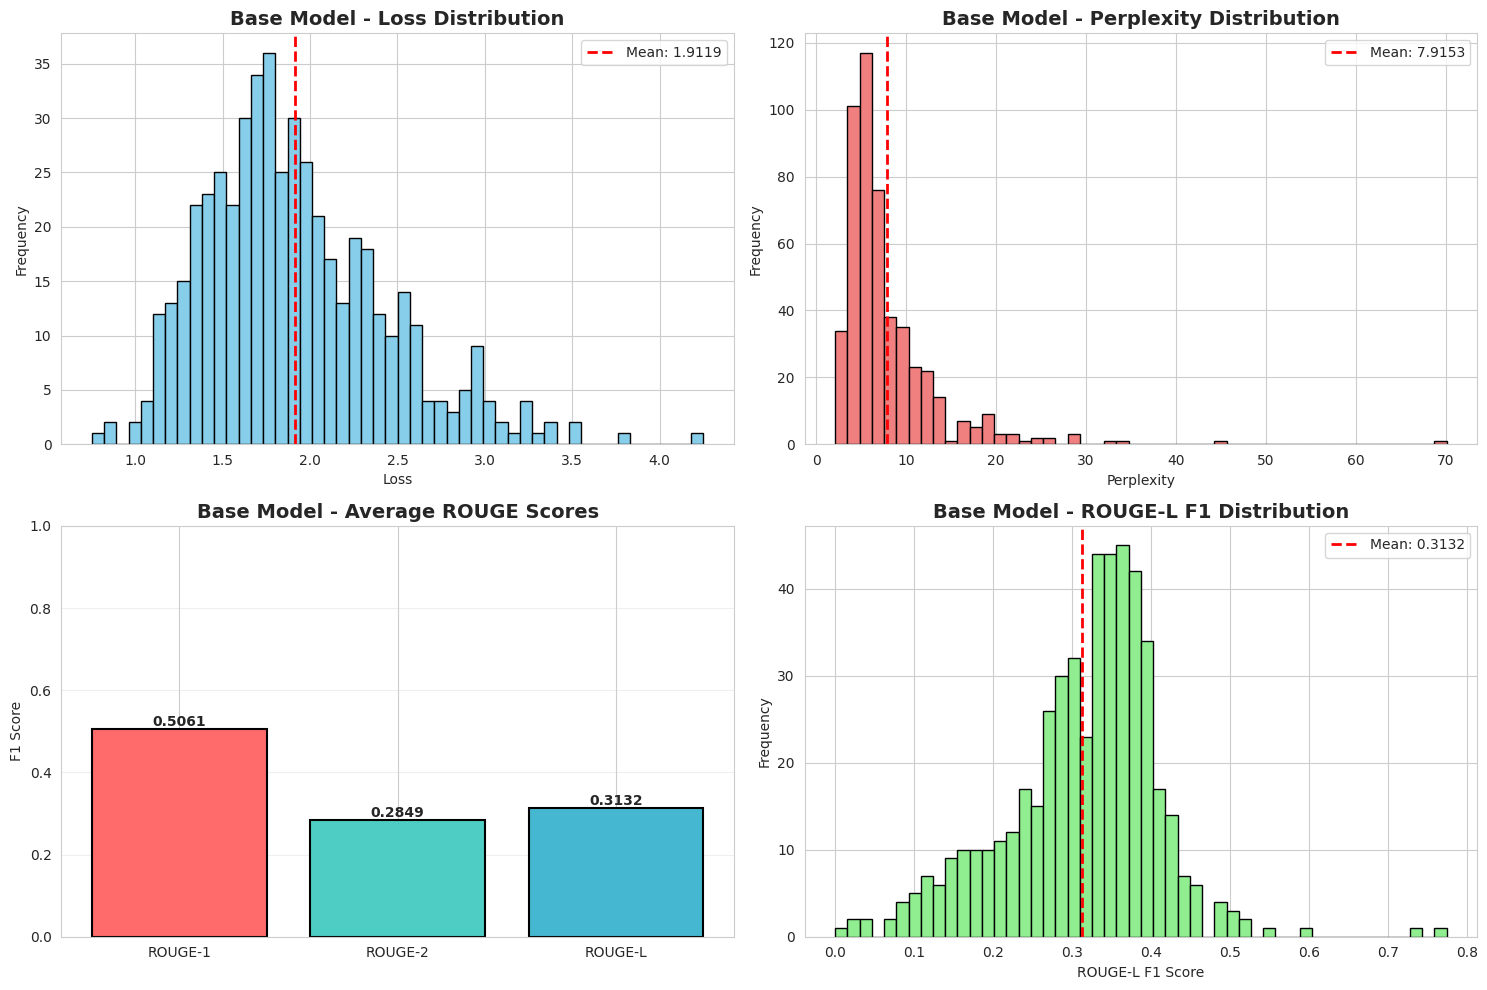

📊 Plots saved to base_model_evaluation_plots.png


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss distribution
axes[0, 0].hist(results['losses'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].axvline(avg_loss, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_loss:.4f}')
axes[0, 0].set_title('Base Model - Loss Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Loss')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Plot 2: Perplexity distribution
axes[0, 1].hist(results['perplexities'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(avg_perplexity, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_perplexity:.4f}')
axes[0, 1].set_title('Base Model - Perplexity Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Perplexity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Plot 3: ROUGE scores comparison
rouge_scores = [avg_rouge1, avg_rouge2, avg_rougeL]
rouge_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = axes[1, 0].bar(rouge_labels, rouge_scores, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_title('Base Model - Average ROUGE Scores', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, rouge_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{score:.4f}',
                    ha='center', va='bottom', fontweight='bold')

# Plot 4: ROUGE-L distribution
axes[1, 1].hist(results['rougeL_f'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 1].axvline(avg_rougeL, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_rougeL:.4f}')
axes[1, 1].set_title('Base Model - ROUGE-L F1 Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('ROUGE-L F1 Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('base_model_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Plots saved to base_model_evaluation_plots.png")

## 11. Example Predictions

In [12]:
# Show some example predictions
num_examples = 5

print("="*80)
print(f"📝 BASE MODEL - EXAMPLE PREDICTIONS (First {num_examples} samples)")
print("="*80)

for i in range(min(num_examples, len(results['predictions']))):
    print(f"\n{'='*80}")
    print(f"Example {i+1}:")
    print(f"{'='*80}")

    # Input
    example = test_data[i]
    print(f"\n📥 INPUT:")
    print(f"Instruction: {example['instruction']}")
    print(f"Question: {example['input'][:200]}...")

    # Reference
    print(f"\n✅ REFERENCE:")
    print(f"{results['references'][i][:300]}...")

    # Prediction
    print(f"\n🤖 BASE MODEL PREDICTION:")
    print(f"{results['predictions'][i][:300]}...")

    # Metrics for this example
    print(f"\n📊 METRICS:")
    print(f"   Loss: {results['losses'][i]:.4f}")
    print(f"   Perplexity: {results['perplexities'][i]:.4f}")
    print(f"   ROUGE-1: {results['rouge1_f'][i]:.4f}")
    print(f"   ROUGE-2: {results['rouge2_f'][i]:.4f}")
    print(f"   ROUGE-L: {results['rougeL_f'][i]:.4f}")

print(f"\n{'='*80}")

📝 BASE MODEL - EXAMPLE PREDICTIONS (First 5 samples)

Example 1:

📥 INPUT:
Instruction: Trả lời câu hỏi pháp luật sau:
Question: Bố thường xuyên đánh mẹ khiến cuộc sống gia đình tôi không hạnh phúc, căng thẳng nhiều năm qua. Chúng tôi giờ đã trưởng thành, nhiều lần khuyên mẹ ly hôn để được giải thoát nhưng bà không đồng ý. Chún...

✅ REFERENCE:
Theo Điều 51 Luật Hôn nhân và Gia đình năm 2014 (có hiệu lực từ ngày 1/1/2015), quyền yêu cầu giải quyết ly hôn được quy định như sau: 1. Vợ, chồng hoặc cả hai người có quyền yêu cầu tòa án giải quyết ly hôn. 2. Cha, mẹ, người thân thích khác có quyền yêu cầu tòa án giải quyết ly hôn khi một bên vợ,...

🤖 BASE MODEL PREDICTION:
Theo quy định tại Điều 42 Bộ luật Dân sự năm 2015, vợ, chồng có quyền yêu cầu tòa án giải quyết việc ly hôn. Tuy nhiên, theo Điều 42 Bộ luật Dân sự năm 2015, các điều kiện để được yêu cầu tòa án giải quyết việc ly hôn là: Đủ 18 tuổi trở lên; Có căn cứ hợp lệ về việc ly hôn; Không thuộc một trong các...

📊 METRICS:
   Loss

## 12. Save Detailed Results

In [13]:
# Save detailed results to JSONL
detailed_results_path = 'base_model_detailed_evaluation_results.jsonl'

with open(detailed_results_path, 'w', encoding='utf-8') as f:
    for i in range(len(results['predictions'])):
        result_item = {
            'id': i,
            'model_type': 'base_model',
            'model_name': BASE_MODEL_NAME,
            'instruction': test_data[i]['instruction'],
            'input': test_data[i]['input'],
            'reference': results['references'][i],
            'prediction': results['predictions'][i],
            'metrics': {
                'loss': float(results['losses'][i]),
                'perplexity': float(results['perplexities'][i]),
                'rouge1_f1': float(results['rouge1_f'][i]),
                'rouge2_f1': float(results['rouge2_f'][i]),
                'rougeL_f1': float(results['rougeL_f'][i]),
            }
        }
        f.write(json.dumps(result_item, ensure_ascii=False) + '\n')

print(f"💾 Detailed results saved to {detailed_results_path}")
print(f"📊 Saved {len(results['predictions'])} predictions with metrics")

💾 Detailed results saved to base_model_detailed_evaluation_results.jsonl
📊 Saved 500 predictions with metrics


## 13. Upload Results to DigitalOcean Spaces (Optional)

In [14]:
# Upload results back to Spaces
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_prefix = f"evaluation_results/base_model_{timestamp}/"

files_to_upload = [
    ('base_model_evaluation_results.json', f'{results_prefix}base_model_evaluation_results.json'),
    ('base_model_detailed_evaluation_results.jsonl', f'{results_prefix}base_model_detailed_evaluation_results.jsonl'),
    ('base_model_evaluation_plots.png', f'{results_prefix}base_model_evaluation_plots.png'),
]

print(f"📤 Uploading results to Spaces: {results_prefix}")

for local_file, spaces_path in files_to_upload:
    try:
        client.upload_file(local_file, DO_SPACES_BUCKET, spaces_path)
        print(f"   ✅ Uploaded {local_file} to {spaces_path}")
    except Exception as e:
        print(f"   ❌ Failed to upload {local_file}: {e}")

print(f"\n✅ All results uploaded to: {results_prefix}")

📤 Uploading results to Spaces: evaluation_results/base_model_20251116_101754/
   ✅ Uploaded base_model_evaluation_results.json to evaluation_results/base_model_20251116_101754/base_model_evaluation_results.json
   ✅ Uploaded base_model_detailed_evaluation_results.jsonl to evaluation_results/base_model_20251116_101754/base_model_detailed_evaluation_results.jsonl
   ✅ Uploaded base_model_evaluation_plots.png to evaluation_results/base_model_20251116_101754/base_model_evaluation_plots.png

✅ All results uploaded to: evaluation_results/base_model_20251116_101754/


## 14. Compare with Fine-tuned Model (Optional)

Nếu bạn đã có kết quả từ fine-tuned model (`evaluation_results.json`), bạn có thể load và so sánh:

In [15]:
import os

# Load fine-tuned model results nếu có
finetuned_results_path = 'evaluation_results.json'

if os.path.exists(finetuned_results_path):
    with open(finetuned_results_path, 'r', encoding='utf-8') as f:
        finetuned_results = json.load(f)

    print("="*80)
    print("📊 COMPARISON: BASE MODEL vs FINE-TUNED MODEL")
    print("="*80)

    # Create comparison table
    metrics = ['avg_loss', 'avg_perplexity', 'avg_rouge1_f1', 'avg_rouge2_f1', 'avg_rougeL_f1']
    metric_names = ['Loss', 'Perplexity', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    print(f"\n{'Metric':<15} {'Base Model':<15} {'Fine-tuned':<15} {'Improvement':<15}")
    print("-"*60)

    for metric, name in zip(metrics, metric_names):
        base_value = results_summary[metric]
        finetuned_value = finetuned_results[metric]

        # Calculate improvement (for ROUGE higher is better, for loss/perplexity lower is better)
        if 'rouge' in metric:
            improvement = ((finetuned_value - base_value) / base_value) * 100
            improvement_str = f"+{improvement:.2f}%" if improvement > 0 else f"{improvement:.2f}%"
        else:
            improvement = ((base_value - finetuned_value) / base_value) * 100
            improvement_str = f"+{improvement:.2f}%" if improvement > 0 else f"{improvement:.2f}%"

        print(f"{name:<15} {base_value:<15.4f} {finetuned_value:<15.4f} {improvement_str:<15}")

    print("="*80)

    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss & Perplexity comparison
    metrics_lp = ['Loss', 'Perplexity']
    base_lp = [results_summary['avg_loss'], results_summary['avg_perplexity']]
    finetuned_lp = [finetuned_results['avg_loss'], finetuned_results['avg_perplexity']]

    x = np.arange(len(metrics_lp))
    width = 0.35

    axes[0].bar(x - width/2, base_lp, width, label='Base Model', color='lightcoral')
    axes[0].bar(x + width/2, finetuned_lp, width, label='Fine-tuned', color='lightgreen')
    axes[0].set_xlabel('Metrics')
    axes[0].set_ylabel('Value')
    axes[0].set_title('Loss & Perplexity Comparison (Lower is Better)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics_lp)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # ROUGE scores comparison
    rouge_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    base_rouge = [results_summary['avg_rouge1_f1'], results_summary['avg_rouge2_f1'], results_summary['avg_rougeL_f1']]
    finetuned_rouge = [finetuned_results['avg_rouge1_f1'], finetuned_results['avg_rouge2_f1'], finetuned_results['avg_rougeL_f1']]

    x = np.arange(len(rouge_labels))

    axes[1].bar(x - width/2, base_rouge, width, label='Base Model', color='lightcoral')
    axes[1].bar(x + width/2, finetuned_rouge, width, label='Fine-tuned', color='lightgreen')
    axes[1].set_xlabel('Metrics')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title('ROUGE Scores Comparison (Higher is Better)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(rouge_labels)
    axes[1].set_ylim(0, 1)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('base_vs_finetuned_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n📊 Comparison plot saved to base_vs_finetuned_comparison.png")

else:
    print("⚠️ Fine-tuned model results not found. Run evaluation_model_colab.ipynb first to compare.")

⚠️ Fine-tuned model results not found. Run evaluation_model_colab.ipynb first to compare.


## 15. Summary & Next Steps

### Kết quả Base Model:

Base model (chưa fine-tune) thường sẽ có:
- **Loss cao hơn** fine-tuned model
- **Perplexity cao hơn** - model ít "tự tin" hơn với Vietnamese legal domain
- **ROUGE scores thấp hơn** - ít overlap với ground truth hơn

### So sánh với Fine-tuned Model:

Fine-tuning giúp:
1. **Giảm Loss & Perplexity**: Model học được patterns của Vietnamese legal language
2. **Tăng ROUGE scores**: Câu trả lời gần với ground truth hơn
3. **Domain adaptation**: Model hiểu rõ hơn về legal terminology và context

### Expected Performance Gap:

Thường thì fine-tuned model sẽ tốt hơn base model khoảng:
- Loss: giảm 20-40%
- ROUGE-L: tăng 15-30%
- Perplexity: giảm 25-50%

### Next Steps:

1. ✅ Chạy `evaluation_model_colab.ipynb` để evaluate fine-tuned model
2. ✅ So sánh kết quả giữa base và fine-tuned model
3. ✅ Phân tích xem fine-tuning có hiệu quả không
4. ✅ Identify cases where base model performs better (if any)
5. ✅ Consider further fine-tuning improvements